# Style Transfer CycleGAN

---
AIDL winter 2.019-2.020 Final Project

Team: Bargallo Enric, Navarro Alex, Planas Ramon, Treviño Nuria

Task: Style Transfer Gan Zebra-Horse and Barça-Madrid





In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import os
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader
from IPython.display import display
from PIL import Image
import numpy as np
import math

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Utils
Some utils with minor importance

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    img = img[:4]
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

def save_batch_images(img, im_name, imtype=np.uint8, unnormalize=True, mean=0.5, std=0.5):
    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255
    img = utils.make_grid(img, nrow=1)

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    
    im = Image.fromarray(image_numpy.astype(imtype))
    im.save(im_name)

## Dataset
Download and prepare datasets horse2zebra & barcelona2madrid


In [0]:
# Download horse2zebra
!mkdir -p ./datasets
!wget -N https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O ./datasets/horse2zebra.zip

# Unzip dataset
!unzip ./datasets/horse2zebra.zip -d ./datasets/

for details.

--2020-04-10 21:06:37--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘./datasets/horse2zebra.zip’

./datasets/horse2ze 100%[===================>] 111.45M  86.5MB/s    in 1.3s    

2020-04-10 21:06:38 (86.5 MB/s) - ‘./datasets/horse2zebra.zip’ saved [116867962/116867962]

Archive:  ./datasets/horse2zebra.zip
   creating: ./datasets/horse2zebra/
   creating: ./datasets/horse2zebra/trainA/
  inflating: ./datasets/horse2zebra/trainA/n02381460_6223.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_1567.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_3354.jpg  
  inflating: ./datasets/horse2zebra/trainA/n02381460_299.jpg  
  inflating: ./datasets/h

In [0]:
# Download barcelona2madrid
!pip install -U -q PyDrive
file_id = "1DTwhwVxta0KK7UPJPHj1YwVA3XmAd2Ju" # final version

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download file
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('./datasets/barcelona2madrid.zip')

# Unzip dataset
!unzip ./datasets/barcelona2madrid.zip -d ./datasets/

# Rename folders
!mv ./datasets/fcBarcelona2fcRealMadrid/ ./datasets/barcelona2madrid


Archive:  ./datasets/barcelona2madrid.zip
   creating: ./datasets/fcBarcelona2fcRealMadrid/
   creating: ./datasets/fcBarcelona2fcRealMadrid/testA/
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1201_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1202_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1203_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1204_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1205_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1206_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1207_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1208_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1209_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1210_Barcelona.jpg  
  inflating: ./datasets/fcBarcelona2fcRealMadrid/testA/1211_Barcelona.jpg  
  inflating: ./d

**Generate Dataset class**

In [0]:
class TwoDatasets(Dataset):

  def __init__(self, root_dirA, root_dirB, batch_size, transform= None):
    self.root_dirA = root_dirA
    self.root_dirB = root_dirB
    self.filelistA = os.listdir(self.root_dirA)
    self.filelistB = os.listdir(self.root_dirB)
    self.transform=transform
    self.batch_size = batch_size

  def __len__(self):
    if len(self.filelistA) < len(self.filelistB):
      num_img = int(len(self.filelistA)/self.batch_size) * self.batch_size
    else:
      num_img = int(len(self.filelistB)/self.batch_size) * self.batch_size
    return num_img

  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_nameA = os.path.join(self.root_dirA, self.filelistA[idx])
    img_nameB = os.path.join(self.root_dirB, self.filelistB[idx])

    imageA = Image.open(img_nameA).convert('RGB')
    imageB = Image.open(img_nameB).convert('RGB')

    if self.transform:
      imageA = self.transform(imageA)
      imageB = self.transform(imageB)

    return imageA, imageB


In [0]:
# Batch size
batch_size = 10
batch_size_test = 1

# Data augmentation and Normalization
image_size = 256
tf_train = transforms.Compose(
    [transforms.Resize(image_size, interpolation=0),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )
image_size_test = 256
tf_test = transforms.Compose(
    [transforms.Resize(image_size_test, interpolation=0),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
    )

horse2zebra_train = TwoDatasets(root_dirA='./datasets/horse2zebra/trainA',root_dirB='./datasets/horse2zebra/trainB', batch_size=batch_size, transform=tf_train)
horse2zebra_test  = TwoDatasets(root_dirA='./datasets/horse2zebra/testA', root_dirB='./datasets/horse2zebra/testB', batch_size=batch_size, transform=tf_test)

barcelona2madrid_train = TwoDatasets(root_dirA='./datasets/barcelona2madrid/trainA',root_dirB='./datasets/barcelona2madrid/trainB', batch_size=batch_size, transform=tf_train)
barcelona2madrid_test  = TwoDatasets(root_dirA='./datasets/barcelona2madrid/testA', root_dirB='./datasets/barcelona2madrid/testB', batch_size=batch_size, transform=tf_test)

## Data Loader
Create data loaders for the horse2zebra dataset

In [0]:
data_loader_train = torch.utils.data.DataLoader(horse2zebra_train, batch_size, shuffle=True)
data_loader_test  = torch.utils.data.DataLoader(horse2zebra_test,  batch_size_test, shuffle=False)

#data_loader_train = torch.utils.data.DataLoader(barcelona2madrid_train, batch_size=batch_size, shuffle=True)
#data_loader_test  = torch.utils.data.DataLoader(barcelona2madrid_test,  batch_size=batch_size_test, shuffle=False)



Show some examples

1060
120


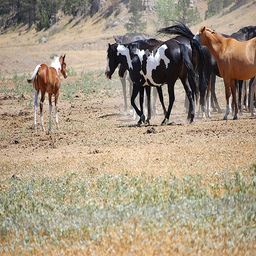

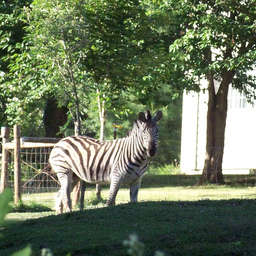

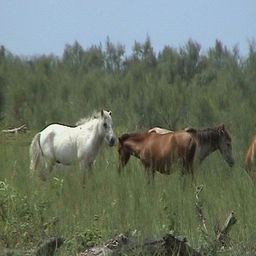

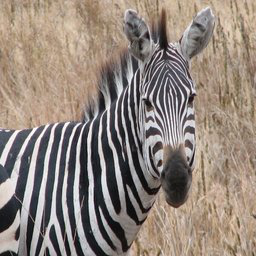

1200
200


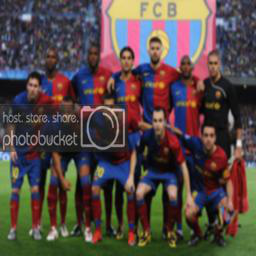

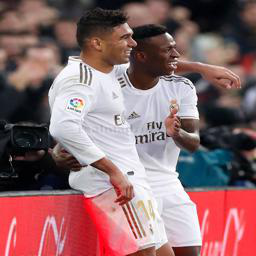

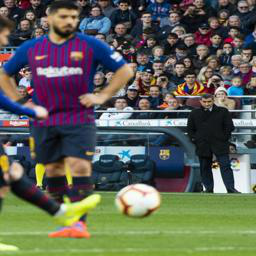

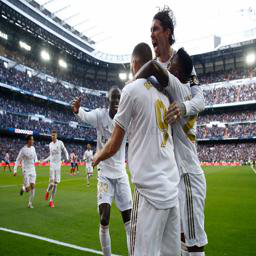

In [0]:
print(len(horse2zebra_train))
print(len(horse2zebra_test))

display_batch_images(horse2zebra_train[0][0])
display_batch_images(horse2zebra_train[0][1])
#
display_batch_images(horse2zebra_test[0][0])
display_batch_images(horse2zebra_test[0][1])

print(len(barcelona2madrid_train))
print(len(barcelona2madrid_test))

display_batch_images(barcelona2madrid_train[0][0])
display_batch_images(barcelona2madrid_train[0][1])
#
display_batch_images(barcelona2madrid_test[0][0])
display_batch_images(barcelona2madrid_test[0][1])

## Networks
First, lets define our simple generator

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder
        self._encoder1 = self.encoder(3, 64, 4)
        self._encoder2 = self.encoder(64, 128, 4)
        self._encoder3 = self.encoder(128, 256, 4)

        # Residual net
        self._res1 = self.residual(256, 256, 3)
        self._res2 = self.residual(256, 256, 3)
        self._res3 = self.residual(256, 256, 3)
        
        # Decoder
        self._decoder1 = self.decoder(256, 128, 4)
        self._decoder2 = self.decoder(128, 64, 4)
        self._decoder3 = self.decoder2(64, 3, 4)

    def encoder(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2)
        )
        return x

    def residual(self, i, o, dim):
        x = nn.Sequential(
            nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2),
            nn.Conv2d(i, o, dim, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.LeakyReLU(0.2)
        )
        return x

    def decoder(self, i, o, dim):
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(o),
            nn.ReLU() 
        )
        return x

    def decoder2(self, i, o, dim): #Same as previous without normalization and changing Relu by Tanh (image values between -1 and 1)
        x = nn.Sequential(
            nn.ConvTranspose2d(i, o, dim, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        return x   

    def forward(self, x):
        # Encode
        x = self._encoder1(x)
        x = self._encoder2(x)
        x = self._encoder3(x)

        # Resnet (the copy of the input take place here)
        a = self._res1(x)
        b = x + a
        c = self._res2(b)
        d = b + c 
        e = self._res3(d)
        x = d + e
    
        # Decode
        x = self._decoder1(x)
        x = self._decoder2(x)
        x = self._decoder3(x)

        return x

Similarly lets define a simple discriminator

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2)
        )
        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(int(512*image_size*image_size/(8*8)), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Classify image as fake or real
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        output = self._fc(x.view(-1, int(512*image_size*image_size/(8*8))))

        return output

## Model
Now lets create the core of our task, the model.

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizers()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generatorA2B = Generator()
        self._generatorB2A = Generator()
        self._discriminatorA = Discriminator()
        self._discriminatorB = Discriminator()

        # init weights
        self._generatorA2B.apply(init_weights)
        self._generatorB2A.apply(init_weights)
        self._discriminatorA.apply(init_weights)
        self._discriminatorB.apply(init_weights)

        # move to cuda
        self._generatorA2B.cuda()
        self._generatorB2A.cuda()
        self._discriminatorA.cuda()
        self._discriminatorB.cuda()
        
    def _create_optimizers(self):
        # generators optimizers
        self._opt_genA2B = torch.optim.Adam(self._generatorA2B.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_genB2A = torch.optim.Adam(self._generatorB2A.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminators optimizers
        self._opt_discrA = torch.optim.Adam(self._discriminatorA.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self._opt_discrB = torch.optim.Adam(self._discriminatorB.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterionGAN = nn.MSELoss()# To fight vanisshing gradients better MSELoss than BCELoss
        self._criterionCYC = nn.L1Loss()# L1 for Cycle Consistency Loss
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samplesA, real_samplesB, lambda_cyc):

        # Reset gradients
        self._opt_genA2B.zero_grad()
        self._opt_genB2A.zero_grad()
        self._opt_discrA.zero_grad()
        self._opt_discrB.zero_grad()

        # generate fake_samples
        fake_samplesA2B = self._generatorA2B(real_samplesA)
        fake_samplesB2A = self._generatorB2A(real_samplesB)

        cyc_samplesA = self._generatorB2A(fake_samplesA2B)
        cyc_samplesB = self._generatorA2B(fake_samplesB2A)

        #
        # optimize generator A2B & B2A
        #
        # discriminators are not updated
        for params in self._discriminatorA.parameters():
          params.requires_grad = False
        for params in self._discriminatorB.parameters():
          params.requires_grad = False

        estim_fakeA = self._discriminatorB(fake_samplesA2B)
        loss_gA = self._criterionGAN(estim_fakeA, self._label_real)
        estim_fakeB = self._discriminatorA(fake_samplesB2A)
        loss_gB = self._criterionGAN(estim_fakeB, self._label_real)
        #
        # Cycle loss
        #
        loss_cycA = self._criterionCYC(real_samplesA, cyc_samplesA)
        loss_cycB = self._criterionCYC(real_samplesB, cyc_samplesB)
        loss_cyc = loss_cycA + loss_cycB
        #
        loss_gA2B = loss_gA + lambda_cyc*loss_cyc
        loss_gB2A = loss_gB + lambda_cyc*loss_cyc
        #
        loss_gA2B.backward(retain_graph=True)
        loss_gB2A.backward(retain_graph=True)
        self._opt_genA2B.step()
        self._opt_genB2A.step()

        #
        # optimize discriminator A
        #
        for params in self._discriminatorA.parameters():
          params.requires_grad = True

        # Calculate discriminator A loss for real samples A
        estim_realA = self._discriminatorA(real_samplesA)
        loss_realA = self._criterionGAN(estim_realA, self._label_real)

        # Calculate discriminator A loss for fake samples B2A
        estim_fakeA = self._discriminatorA(fake_samplesB2A.detach())
        loss_fakeA = self._criterionGAN(estim_fakeA, self._label_fake)

        # Total discriminator loss
        loss_dA = (loss_realA + loss_fakeA) / 2
        loss_dA.backward()
        self._opt_discrA.step()
        
        #
        # optimize discriminator B
        #
        for params in self._discriminatorB.parameters():
          params.requires_grad = True

        # Calculate discriminator B loss for real samples B
        estim_realB = self._discriminatorB(real_samplesB)
        loss_realB = self._criterionGAN(estim_realB, self._label_real)

        # Calculate discriminator B loss for fake samples A2B
        estim_fakeB = self._discriminatorB(fake_samplesA2B.detach())
        loss_fakeB = self._criterionGAN(estim_fakeB, self._label_fake)

        # Total discriminator loss
        loss_dB = (loss_realB + loss_fakeB) / 2
        loss_dB.backward()
        self._opt_discrB.step()

        return loss_gA2B.item(), loss_gB2A.item(), loss_dA.item(), loss_dB.item(), loss_cyc.item()
             

## Train

In [0]:
num_epochs = 101
lambda_cyc = 5              # multiplier of the Cycle Consistency loss
output_test_images = True   # Output of images from test dataset (True or False)
output_test_epoch = 10       # Frequency of epochs to output test images
#
model = Model(batch_size)

In [14]:
# Remember to Mount Drive to export images to Google Drive
if output_test_images:
    !mkdir -p '/content/gdrive/My Drive/results'
    !mkdir -p '/content/gdrive/My Drive/results/testA'
    !mkdir -p '/content/gdrive/My Drive/results/testB'
    output_pathA = '/content/gdrive/My Drive/results/testA/'
    output_pathB = '/content/gdrive/My Drive/results/testB/'
#
for epoch in range(num_epochs):
    # Train epoch
    for n_batch, (real_samplesA, real_samplesB) in enumerate(data_loader_train):

        # Prepare batch data
        real_samplesA = Variable(real_samplesA).cuda()
        real_samplesB = Variable(real_samplesB).cuda()

        # Update model weights
        loss_gA2B, loss_gB2A, loss_dA, loss_dB, loss_cyc = model.step_optimization(real_samplesA, real_samplesB, lambda_cyc)
        
        # Show fake samples
        if n_batch == 10 and (epoch) % 10 == 0:
            fake_samplesA = model._generatorA2B(real_samplesA)
            fake_samplesB = model._generatorB2A(fake_samplesA)
            display_batch_images(real_samplesA)
            display_batch_images(fake_samplesA.detach())
            display_batch_images(fake_samplesB.detach())

    # Output test images
    if (epoch) % output_test_epoch == 0:
        print('Output test images at epoch %s' % epoch)
        for n_batch_test, (samplesA, samplesB) in enumerate(data_loader_test):
            # Prepare batch data
            samplesA = Variable(samplesA).cuda()
            samplesB = Variable(samplesB).cuda()
            #
            fakeA = model._generatorA2B(samplesA)
            cycA = model._generatorB2A(fakeA)
            # Save images
            save_batch_images(fakeA.detach(), output_pathA+'%s_fakeA_epoch%s.png' % (n_batch_test+1, epoch))
            save_batch_images(cycA.detach(), output_pathA+'%s_cycA_epoch%s.png' % (n_batch_test+1, epoch))
            #
            fakeB = model._generatorB2A(samplesB)
            cycB = model._generatorA2B(fakeB)
            # Save images
            save_batch_images(fakeB.detach(), output_pathB+'%s_fakeB_epoch%s.png' % (n_batch_test+1, epoch))
            save_batch_images(cycB.detach(), output_pathB+'%s_cycB_epoch%s.png' % (n_batch_test+1, epoch))

    # Show current loss
    print(f"epoch: {epoch+1}/{num_epochs}, batch: {n_batch+1}/{len(data_loader_train)}, GA2B_loss: {loss_gA2B}, GB2A_loss: {loss_gB2A}")
    print(f"                             DA_loss: {loss_dA}, DB_loss: {loss_dB}, CYC_loss: {loss_cyc}")    
          


Output hidden; open in https://colab.research.google.com to view.